In [47]:
import time
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200
import numpy as np
from stemsegmentation import segmentationSTEM

In [2]:
from scipy.io import loadmat

In [217]:
image = np.load('image1.npy')

In [218]:
pixel_size= 0.1761

In [219]:
atoms = loadmat('image_2_coordinates.mat')

In [220]:
atoms = atoms['ans'] / pixel_size

In [221]:
tt = atoms[:,0].copy()
atoms[:,0] = 1.*atoms[:,1]
atoms[:,1] = 1.*tt
atoms = atoms[:,0:2]

In [222]:
add_atoms = np.array(([[939,29],[941,55],[859,120]]))

In [223]:
atoms = np.concatenate( [atoms,add_atoms], axis=0)

In [224]:
del tt

In [225]:
#https://lammps.sandia.gov/doc/compute_centro_atom.html
number_neigh = 6
int_half = int(number_neigh/2)
descriptors = np.zeros(len(atoms))
for i,atom in enumerate(atoms):
    distances = np.linalg.norm( atoms[:] - atom,axis=1)
    neighbours = np.argpartition(distances, number_neigh)[:(number_neigh+1)]
    neighbours = np.delete(neighbours, np.where(neighbours==i))
    pairs = []
    for j in range(len(neighbours)):
        for k in range(j+1,len(neighbours)):
            v1 = atoms[neighbours[j]] - atom
            v2 = atoms[neighbours[k]] - atom
            sum12 = v1+v2
            pairs += [ np.sum(sum12*sum12),]
    pairs = np.sort(pairs)[:int_half]
    descriptors[i] = np.sum(pairs)

In [226]:
from scipy import interpolate

In [227]:
shape = image.shape
x,y = np.meshgrid(np.arange(shape[0]),np.arange(shape[1]))
x = x.T
y = y.T
row = x.flatten()
col  = y.flatten()
coords = np.vstack((row, col)).T

In [228]:
a = interpolate.griddata(atoms[:,0:2],descriptors,coords,method='cubic')

In [229]:
a = np.reshape(a, shape)

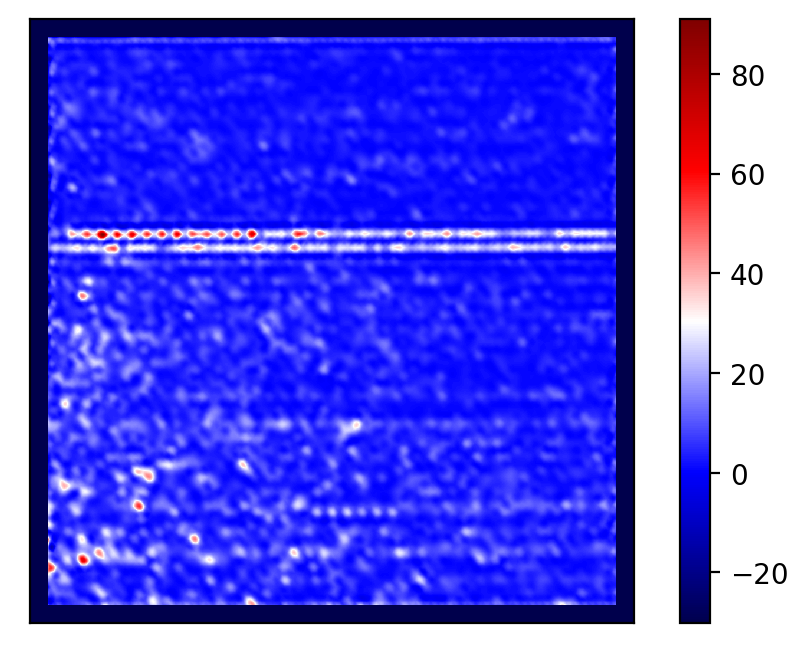

In [248]:
import matplotlib
border = 30
a[0:border,:] = np.min(a)
a[:,0:border] = np.min(a)
a[(shape[0]-border):,:] = np.min(a)
a[:,(shape[0]-border):] = np.min(a)
fig, ax = plt.subplots()
im = plt.imshow(a,cmap=matplotlib.cm.seismic)
#plt.imshow(a[border:(1024-border),border:(1024-border)],cmap=matplotlib.cm.seismic)
plt.xticks([])
plt.yticks([])
fig.colorbar(im, ax=ax)

([], <a list of 0 Text yticklabel objects>)

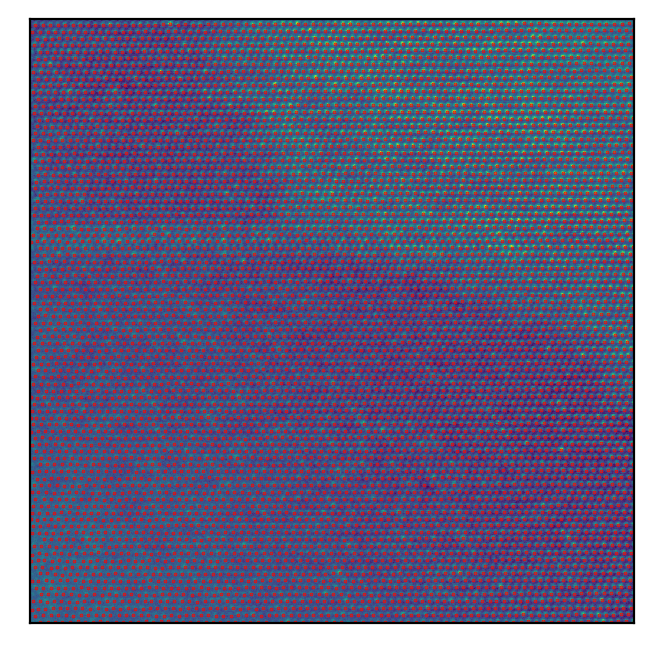

In [255]:
plt.imshow(image)
plt.plot(atoms[:,1],atoms[:,0],'ro',markersize=0.3)
plt.xlim(0,1024)
plt.xticks([])
plt.yticks([])
#plt.plot([120],[859],'bo',markersize=4)
#plt.plot([55],[941],'bo',markersize=4)
#plt.xlim(100,200)
#plt.ylim(800,900)

In [250]:
methods_implemented = ['simplified','full']
def generate_synthetic_image(image,atoms,atomic_size=8,method='simplifed'):
    synthetic_image = np.zeros_like(image, dtype=np.float32)
    if method is 'simplified':
        atoms = atoms.astype(np.int32)
        sigma = 0.5*atomic_size
        int_s = int(sigma)
        int_s = max(int_s, 1)
        cutoff = 5
        x,y = np.meshgrid(np.arange(2*cutoff*int_s+1),np.arange(2*cutoff*int_s+1))
        center_x = cutoff*int_s
        center_y = cutoff*int_s
        gaussian = np.exp(-((x-center_x)**2 + (y-center_y)**2)/(2*sigma**2))
        shape = image.shape
        for atom in atoms:
            if atom[0] - cutoff*int_s < 0:
                x_len_l = atom[0]
            else:
                x_len_l = cutoff*int_s
            
            if atom[0] + cutoff*int_s > shape[0]-1:
                x_len_r = shape[0]-1 - atom[0]
            else:
                x_len_r = cutoff*int_s
            
            if atom[1] - cutoff*int_s < 0:
                y_len_l = atom[1]
            else:
                y_len_l = cutoff*int_s
            
            if atom[1] + cutoff*int_s > shape[1]-1:
                y_len_r = shape[1]-1 - atom[1]
            else:
                y_len_r = cutoff*int_s 
            synthetic_image[(atom[0]-x_len_l):(atom[0]+x_len_r+1),(atom[1]-y_len_l):(atom[1]+y_len_r+1)]  +=\
                gaussian[(center_x-x_len_l):(center_x+x_len_r+1),(center_y-y_len_l):(center_y+y_len_r+1)]
    else:
        sigma = 0.5*atomic_size
        cutoff = 5
        shape = image.shape
        for atom in atoms:
            x_l = max(int(atom[0]-5*sigma),0)
            x_r = min(int(atom[0]+5*sigma),shape[0]-1)
            y_l = max(int(atom[1]-5*sigma),0)
            y_r = min(int(atom[1]+5*sigma),shape[1]-1)
            x,y = np.meshgrid(np.arange(x_l,x_r+1), np.arange(y_l,y_r+1))
            x = x.T
            y = y.T
            synthetic_image[x_l:(x_r+1),y_l:(y_r+1)] += np.exp( -((x-atom[0])**2+(y-atom[1])**2)/(2*sigma**2) )
    return synthetic_image
    #return gaussian

In [251]:
synthetic_image = generate_synthetic_image(image,atoms,method='full')

([], <a list of 0 Text yticklabel objects>)

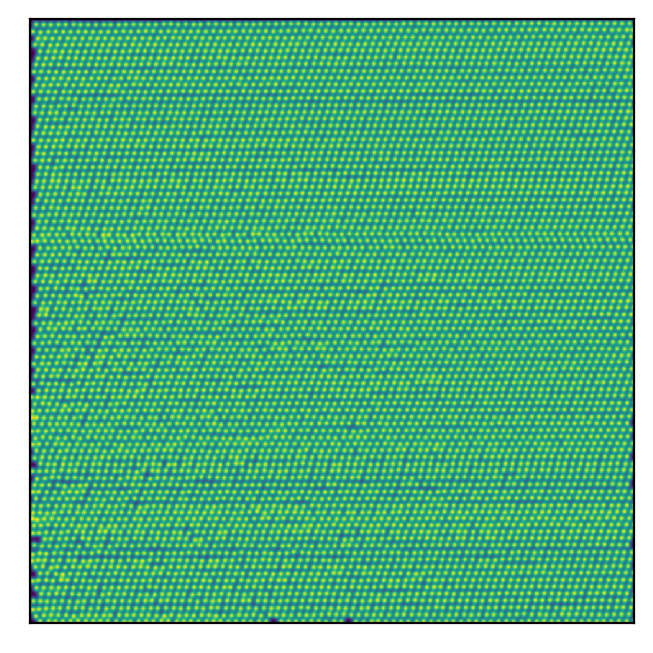

In [253]:
plt.imshow(synthetic_image[:,:])
plt.xticks([])
plt.yticks([])

In [151]:
#https://lammps.sandia.gov/doc/compute_centro_atom.html#kelchner

In [147]:
# perform segmentation on the raw image
step = 5
patch_x = 20
patch_y = 20
window_x = 20
window_y = 20
descriptor_name = 'local_correlation_map'
seg = segmentationSTEM( n_patterns=2,
                       window_x=window_x,window_y=window_y,
                       patch_x=patch_x,patch_y=patch_y,
                       step=step,
                       descriptor_name=descriptor_name,
                       max_num_points=200,
                       upsampling=True)
start = time.time()
labels = seg.perform_clustering(synthetic_image)
print ('time_cost: %6.2f[s]' %(time.time()-start,))

method: direct
time_cost:  10.57[s]


Text(0.5, 1.0, 'Segmentation on the raw image')

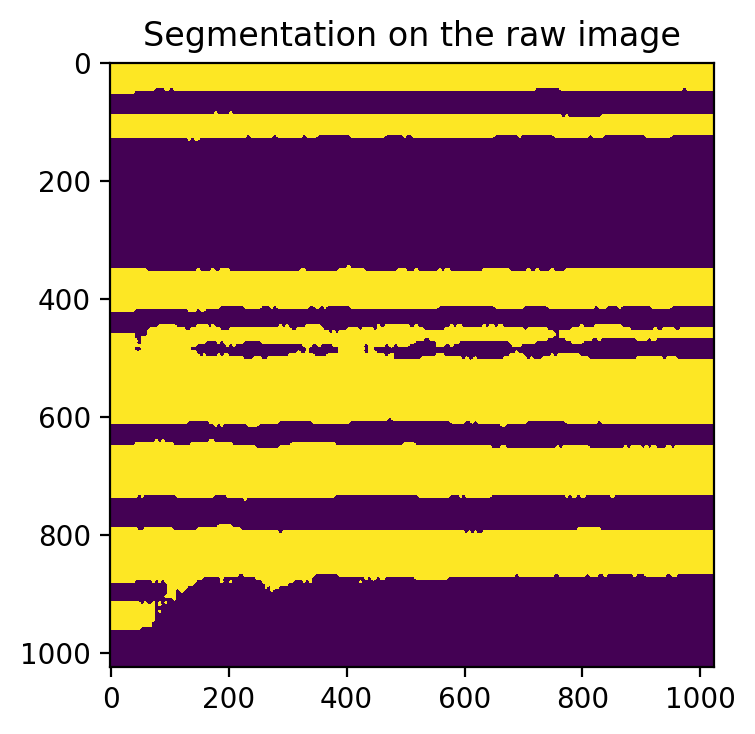

In [148]:
plt.imshow(labels)
plt.title('Segmentation on the raw image')

In [12]:
from skimage.morphology import opening, disk

In [13]:
filtered1 = opening(image, disk(3))

In [14]:
labels = seg.perform_clustering(filtered1)

method: direct


Text(0.5, 1.0, 'Segmentation on the filtered image')

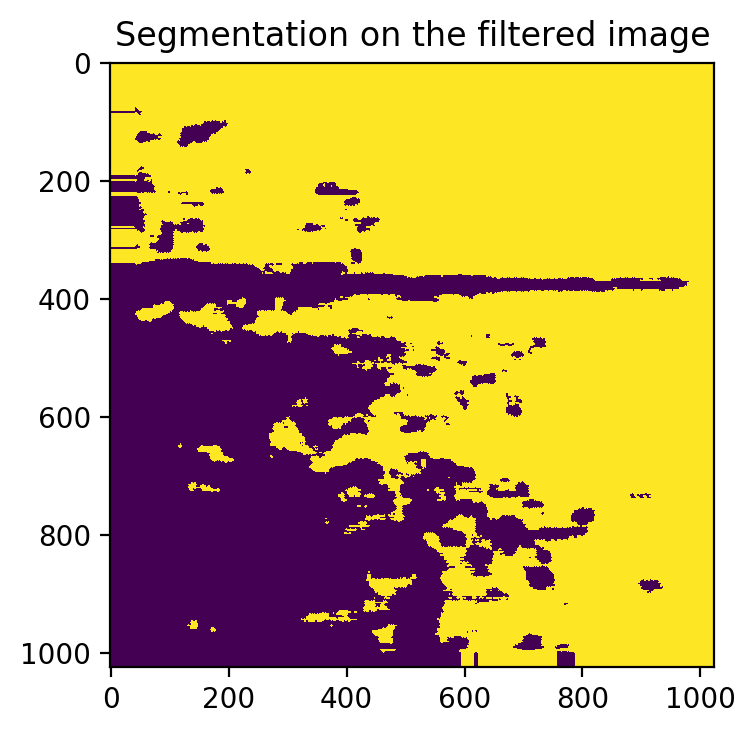

In [16]:
plt.imshow(labels)
plt.title('Segmentation on the filtered image')

In [38]:
from skimage.feature import peak_local_max
coordinates = peak_local_max(filtered1, min_distance=6)

In [44]:
threshold=0
dilation = ndi.maximum_filter(image, size=5, mode='constant')
coords_max = np.asarray(np.nonzero( (image == dilation) * (image > threshold) )).T

In [45]:
len(coordinates)

135481

(0, 200)

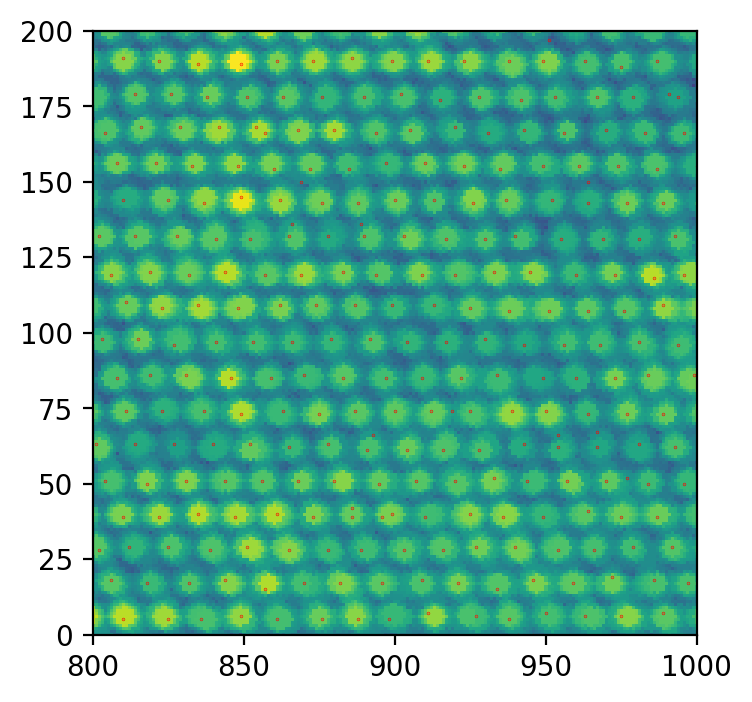

In [48]:
plt.plot(coords_max[:,1],coords_max[:,0],'ro',markersize=0.2)
plt.imshow(filtered1)
plt.xlim(800,1000)
plt.ylim(0,200)

(0, 200)

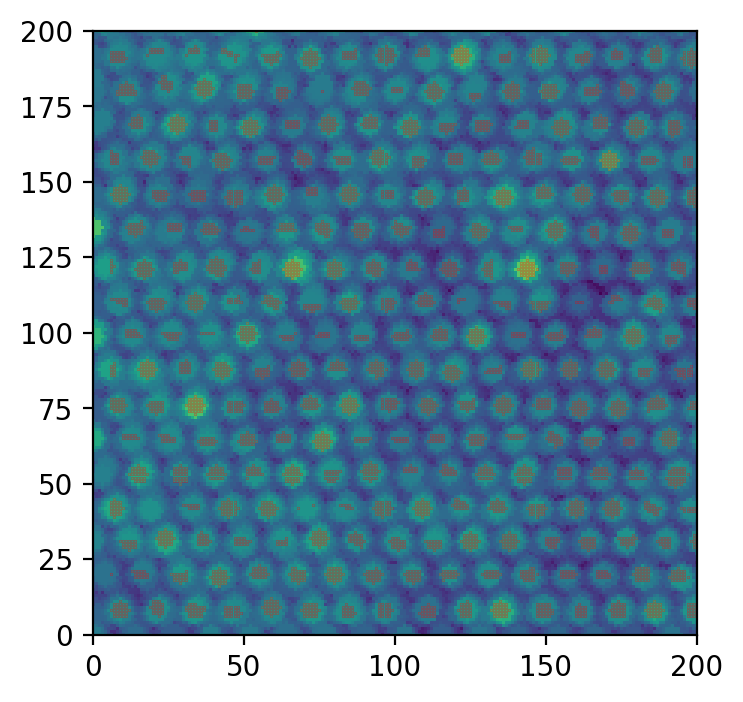

In [40]:
plt.plot(coordinates[:,1],coordinates[:,0],'ro',markersize=0.1)
plt.imshow(filtered1)
plt.xlim(0,200)
plt.ylim(0,200)

In [21]:
coordinates.shape

(56065, 2)

In [136]:
3/8

0.375

In [166]:
peak_local_max(image, min_distance=3.)

TypeError: slice indices must be integers or None or have an __index__ method

In [197]:
from scipy import ndimage as ndi
from sklearn.cluster import MeanShift
from skimage.feature import peak_local_max
def findAtomicColumn(image,atomic_size=10,threshold=0.2,local_max_method=2):
    image = image.astype(np.float32)
    dilation_size=atomic_size
    mean_shift_band_width=atomic_size
    if local_max_method == 1:
        dilation = ndi.maximum_filter(image, size=dilation_size, mode='constant')
        coords_max = np.asarray(np.nonzero( (image == dilation) * (image > threshold) )).T
    else:
        coords_max = peak_local_max(image, min_distance=int(atomic_size/2))
    clusters = MeanShift(bandwidth=mean_shift_band_width).fit(coords_max)
    positions = clusters.cluster_centers_
    print ("%d atomic columns found" % (len(positions)))
    return positions

def generate_synthetic_image(image, atomic_columns, atomic_size):
    synthetic_image = np.zeros_like(image,dtype=np.float32)
    sigma = 0.4*atomic_size
    int_s = int(sigma)
    cutoff = 4
    x_g, y_g = np.meshgrid(np.arange(2*cutoff*int_s+1), np.arange(2*cutoff*int_s+1))
    dd = (x_g - times*int_s)*(x_g - cutoff*int_s) + (y_g - times*int_s)*(y_g - cutoff*int_s) 
    gaussian =  np.exp(-( dd / ( 2.0 * sigma**2 ) ) )

    for coord in atomic_columns:    
        coord = coord.astype(np.int32)
        x_l = max((coord[0]-times*int_s),0)
        x_r = min((coord[0]+times*int_s),shape[0]-1)
        y_l = max((coord[1]-times*int_s),0)
        y_r = min((coord[1]+times*int_s),shape[1]-1)
    
        len_l = coord[0] - x_l
        len_r = x_r - coord[0]
        x_l_g = times*int_s - len_l
        x_r_g = times*int_s + len_r
    
        len_l = coord[1] - y_l
        len_r = y_r - coord[1]
        y_l_g = times*int_s - len_l
        y_r_g = times*int_s + len_r
        synthetic_image[x_l:(x_r+1),y_l:(y_r+1)] += gaussian[x_l_g:(x_r_g+1),y_l_g:(y_r_g+1)]
    return synthetic_image

In [204]:
atomic_columns = findAtomicColumn(image,atomic_size=6.,threshold=5000,)

7139 atomic columns found


In [205]:
synthetic_image = generate_synthetic_image(image, atomic_columns, atomic_size=7.)

(200, 400)

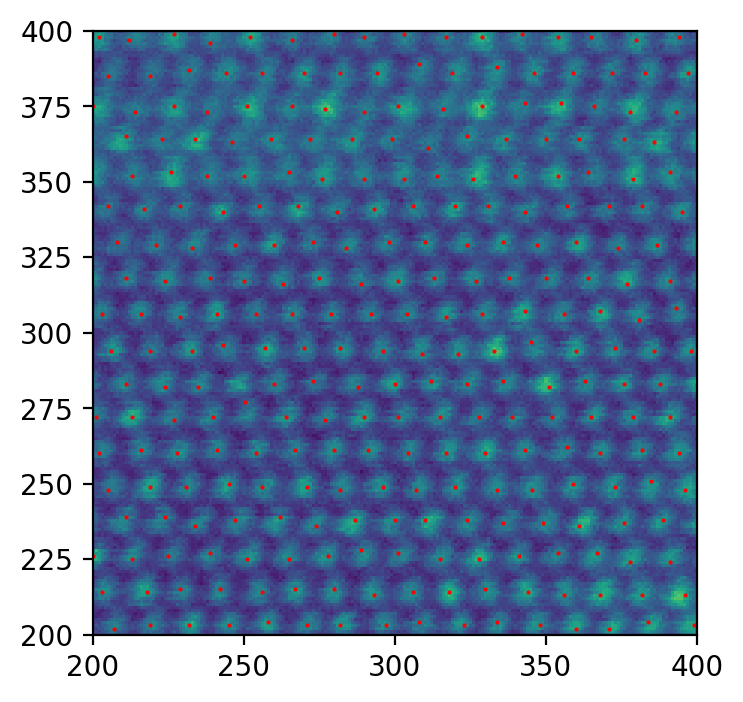

In [206]:
plt.imshow(image)
plt.plot(atomic_columns[:,1], atomic_columns[:,0],'ro',markersize=0.5)
plt.xlim(200,400)
plt.ylim(200,400)

(200, 400)

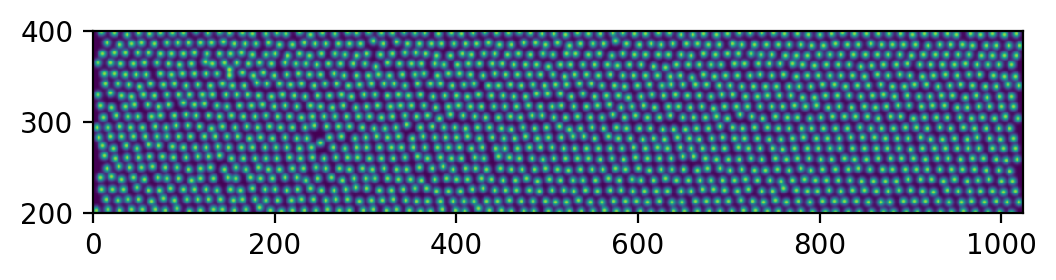

In [207]:
plt.imshow(synthetic_image)
#plt.xlim(0,200)
plt.ylim(200,400)

In [78]:
x, y = np.meshgrid(np.linspace(-1,1,10), np.linspace(-1,1,10))
d = np.sqrt(x*x+y*y)
sigma, mu = 1.0, 0.0
g = np.exp(-( (d-mu)**2 / ( 2.0 * sigma**2 ) ) )
print("2D Gaussian-like array:")
print(g)

2D Gaussian-like array:
[[0.36787944 0.44822088 0.51979489 0.57375342 0.60279818 0.60279818
  0.57375342 0.51979489 0.44822088 0.36787944]
 [0.44822088 0.54610814 0.63331324 0.69905581 0.73444367 0.73444367
  0.69905581 0.63331324 0.54610814 0.44822088]
 [0.51979489 0.63331324 0.73444367 0.81068432 0.85172308 0.85172308
  0.81068432 0.73444367 0.63331324 0.51979489]
 [0.57375342 0.69905581 0.81068432 0.89483932 0.9401382  0.9401382
  0.89483932 0.81068432 0.69905581 0.57375342]
 [0.60279818 0.73444367 0.85172308 0.9401382  0.98773022 0.98773022
  0.9401382  0.85172308 0.73444367 0.60279818]
 [0.60279818 0.73444367 0.85172308 0.9401382  0.98773022 0.98773022
  0.9401382  0.85172308 0.73444367 0.60279818]
 [0.57375342 0.69905581 0.81068432 0.89483932 0.9401382  0.9401382
  0.89483932 0.81068432 0.69905581 0.57375342]
 [0.51979489 0.63331324 0.73444367 0.81068432 0.85172308 0.85172308
  0.81068432 0.73444367 0.63331324 0.51979489]
 [0.44822088 0.54610814 0.63331324 0.69905581 0.73444367 0

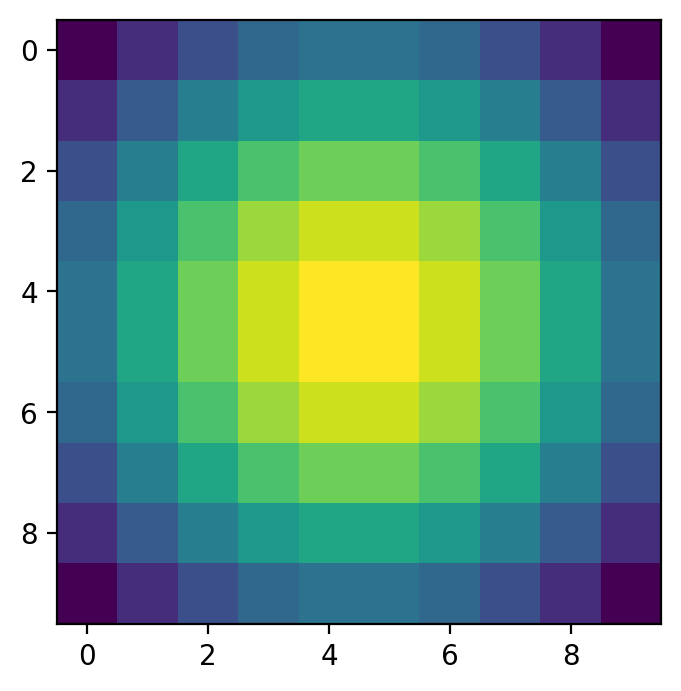

In [79]:
plt.imshow(g)

In [157]:
descriptors = seg._descriptors
features = seg._PCA_components

In [158]:
features.shape

(944, 944, 5)

In [159]:
descriptors.shape

(944, 944, 81)

In [162]:
d1 = s.data[360:390,:]

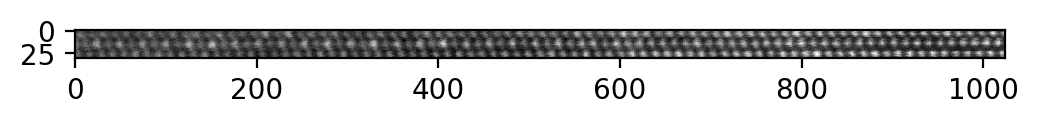

In [163]:
plt.imshow(d1)

In [190]:
features_twin = features[(patch_x+window_x+375):(patch_x+window_x+376),:]
shape = features_twin.shape
features_twin = np.reshape(features_twin, (-1, shape[-1]))
descriptors_twin = descriptors[(patch_x+window_x+375):(patch_x+window_x+376),:]
shape = descriptors_twin.shape
descriptors_twin = np.reshape(descriptors_twin, (-1, shape[-1]))

In [191]:
features_matrix = features[(patch_x+window_x+50):(patch_x+window_x+150),:]
shape = features_matrix.shape
features_matrix = np.reshape(features_matrix, (-1, shape[-1]))
descriptors_matrix = descriptors[(patch_x+window_x+50):(patch_x+window_x+150),:]
shape = descriptors_matrix.shape
descriptors_matrix = np.reshape(descriptors_matrix, (-1, shape[-1]))

In [192]:
descriptors_twin.shape

(944, 81)

In [193]:
motif_twin = np.mean(descriptors_twin,axis=0,keepdims=True)
motif_matrix = np.mean(descriptors_matrix,axis=0,keepdims=True)

In [200]:
#distance1 = np.linalg.norm(descriptors_matrix - motif_twin, axis=1)
#distance2 = np.linalg.norm(descriptors_matrix - motif_matrix, axis=1)
descriptors.shape

(944, 944, 81)

In [203]:
shape = descriptors.shape
distance1 = np.linalg.norm( np.reshape(descriptors, (-1,shape[-1])) - motif_twin, axis=1)
distance2 = np.linalg.norm( np.reshape(descriptors, (-1,shape[-1])) - motif_matrix, axis=1)
distance1 = np.reshape(distance1, (shape[0],shape[1]))
distance2 = np.reshape(distance2, (shape[0],shape[1]))

(array([  215.,  3511., 10110., 14620., 19367., 21968., 26615., 33698.,
        40734., 46846., 48868., 44102., 44960., 44083., 43911., 41438.,
        38656., 34141., 29505., 28996., 27510., 31300., 31074., 26547.,
        26093., 26109., 23695., 18500., 16054., 15396., 12303.,  7150.,
         4736.,  3486.,  2482.,  1099.,   528.,   488.,   176.,    66.]),
 array([0.2155656 , 0.27585697, 0.33614832, 0.39643967, 0.45673102,
        0.5170224 , 0.5773137 , 0.6376051 , 0.6978964 , 0.7581878 ,
        0.8184791 , 0.8787705 , 0.9390618 , 0.9993532 , 1.0596446 ,
        1.1199359 , 1.1802273 , 1.2405186 , 1.30081   , 1.3611013 ,
        1.4213927 , 1.481684  , 1.5419754 , 1.6022667 , 1.6625581 ,
        1.7228494 , 1.7831408 , 1.8434321 , 1.9037235 , 1.9640148 ,
        2.024306  , 2.0845976 , 2.1448889 , 2.2051802 , 2.2654715 ,
        2.325763  , 2.3860543 , 2.4463456 , 2.5066369 , 2.5669284 ,
        2.6272197 ], dtype=float32),
 <a list of 40 Patch objects>)

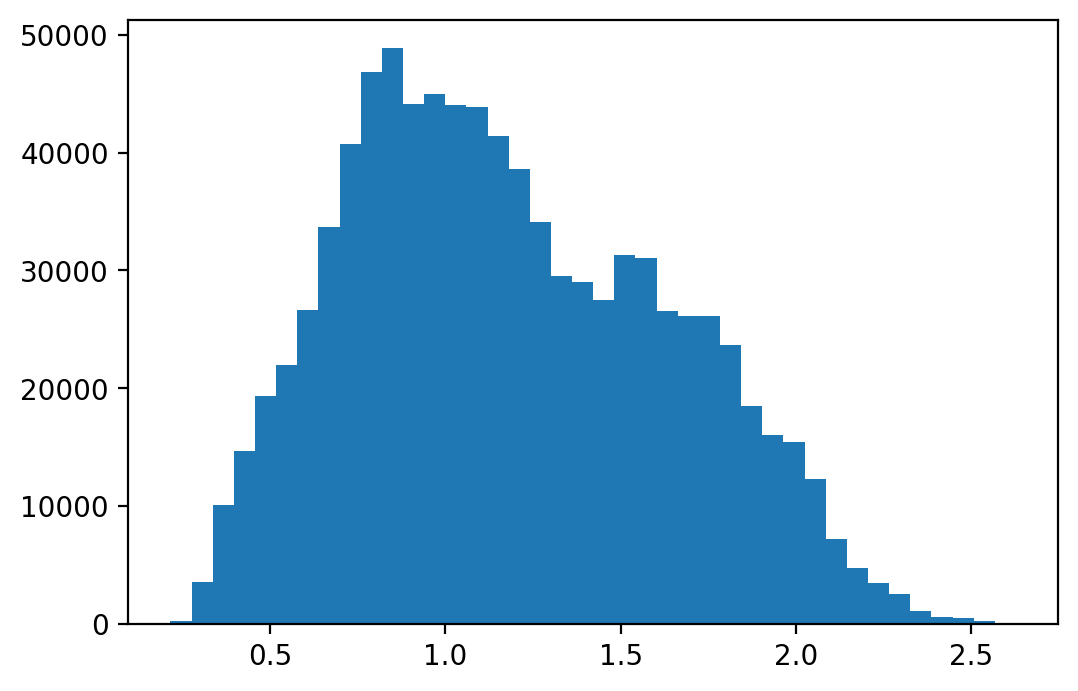

In [208]:
plt.hist(np.reshape(distance2,(-1)),bins=40)

(array([1.8700e+02, 8.2100e+02, 2.0150e+03, 5.2570e+03, 1.0207e+04,
        1.6236e+04, 2.1795e+04, 2.8099e+04, 3.6619e+04, 4.4829e+04,
        4.9794e+04, 5.1347e+04, 5.2327e+04, 5.2556e+04, 5.2617e+04,
        5.2069e+04, 5.0146e+04, 4.6843e+04, 4.1423e+04, 3.4576e+04,
        3.1190e+04, 2.6395e+04, 2.4419e+04, 2.4703e+04, 2.2060e+04,
        1.9792e+04, 1.7701e+04, 1.5595e+04, 1.4006e+04, 1.2781e+04,
        1.0867e+04, 7.8640e+03, 5.4260e+03, 3.7110e+03, 2.4440e+03,
        1.2990e+03, 6.7900e+02, 2.7800e+02, 1.2200e+02, 4.1000e+01]),
 array([0.25107753, 0.30026138, 0.34944522, 0.39862907, 0.4478129 ,
        0.49699676, 0.5461806 , 0.59536445, 0.6445483 , 0.69373214,
        0.742916  , 0.7920999 , 0.84128374, 0.8904676 , 0.9396514 ,
        0.9888353 , 1.0380191 , 1.0872029 , 1.1363868 , 1.1855706 ,
        1.2347546 , 1.2839384 , 1.3331223 , 1.3823061 , 1.43149   ,
        1.4806738 , 1.5298576 , 1.5790415 , 1.6282253 , 1.6774092 ,
        1.726593  , 1.7757769 , 1.8249607 , 1.

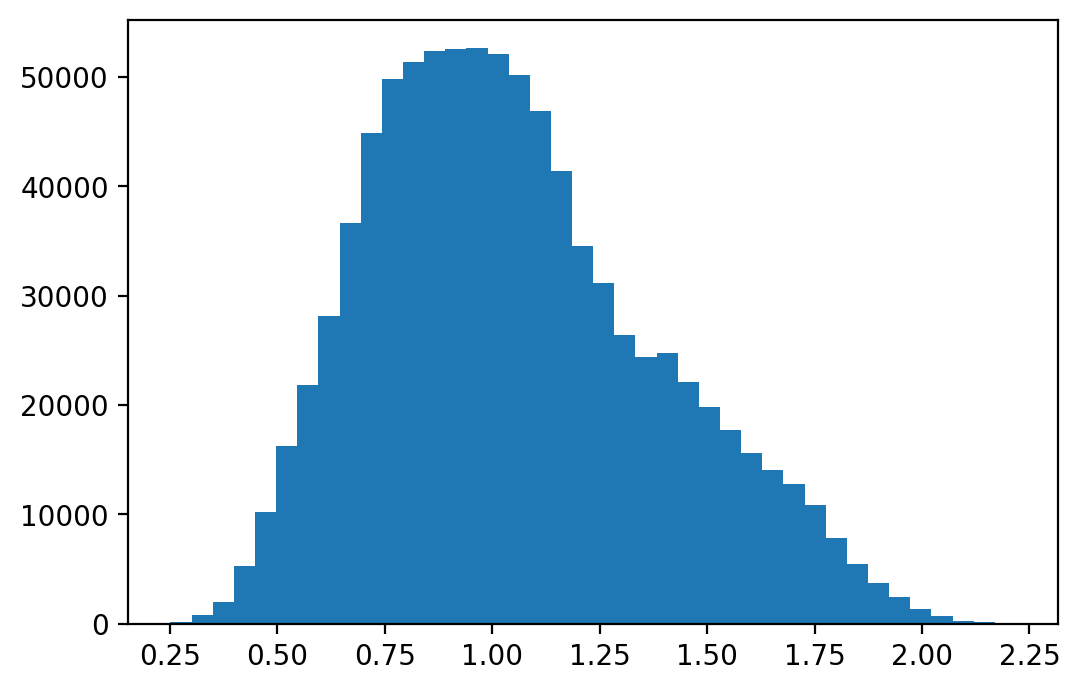

In [207]:
plt.hist(np.reshape(distance1,(-1)),bins=40)

In [210]:
features.shape

(944, 944, 5)

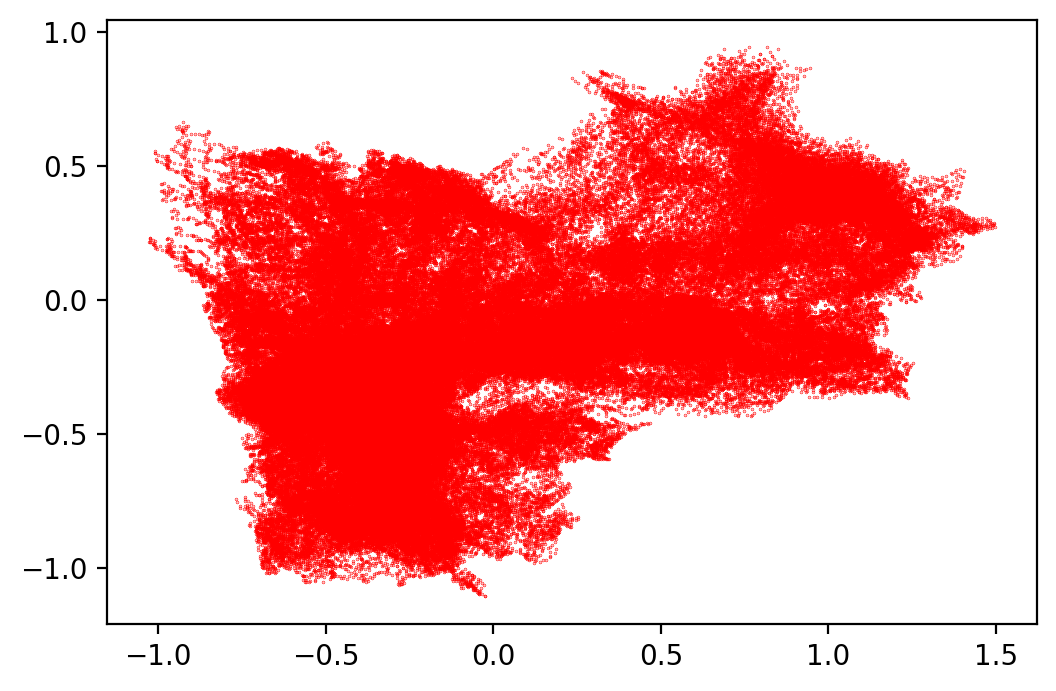

In [216]:
plt.plot(np.reshape(features[:500,:500,0],(-1)),np.reshape(features[:500,:500,1],(-1)), 'ro',markersize=0.2 )

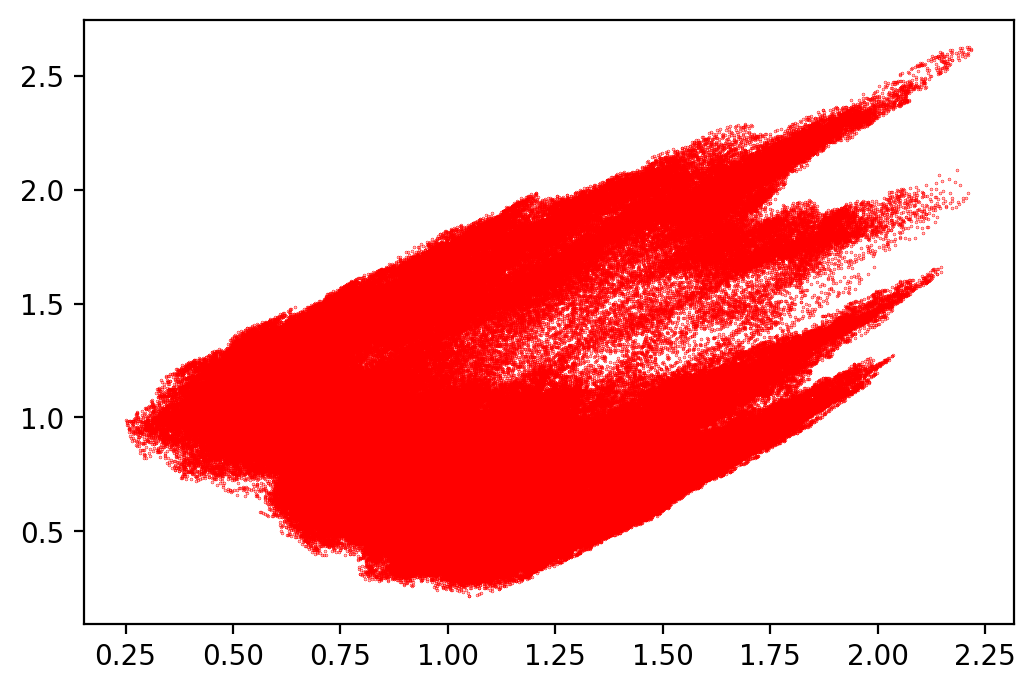

In [215]:
plt.plot(np.reshape(distance1[0:500,:],(-1)),np.reshape(distance2[0:500,:],(-1)), 'ro',markersize=0.2 )

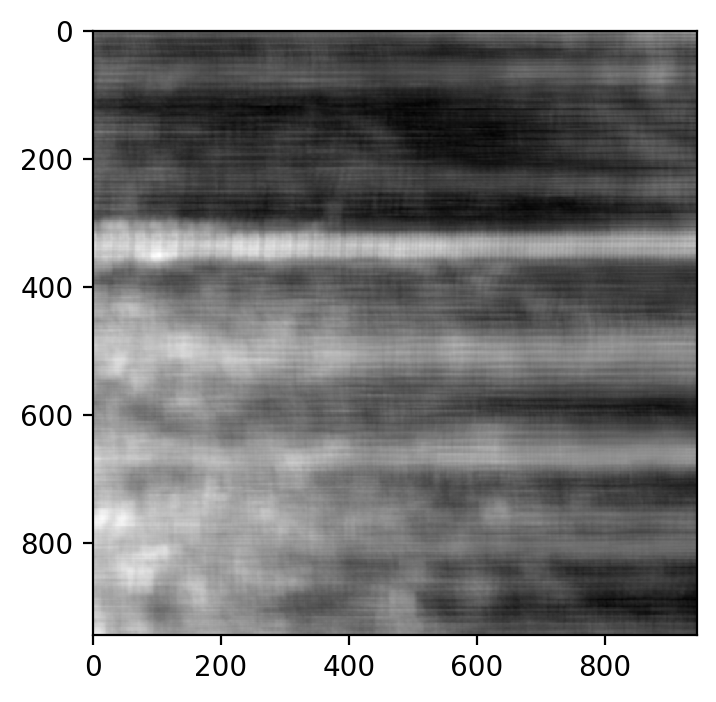

In [205]:
plt.imshow(distance2)

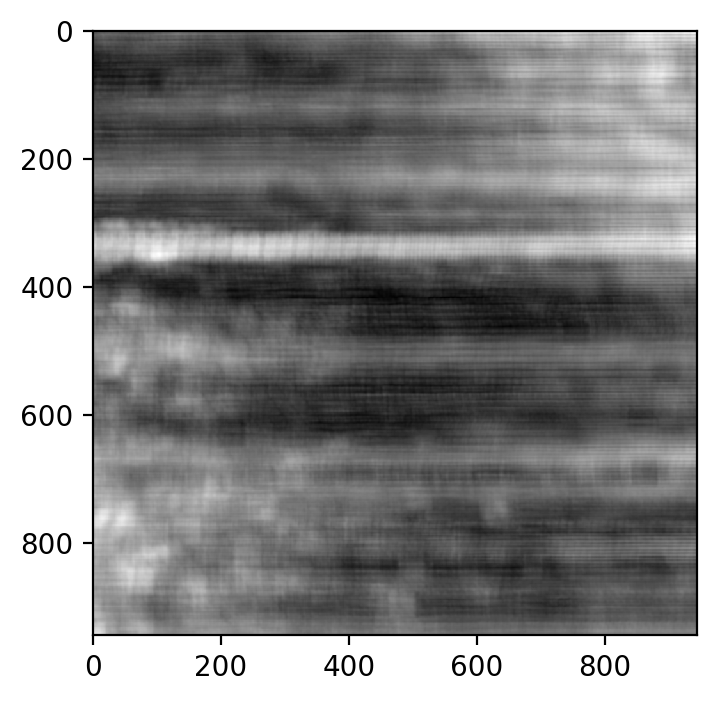

In [204]:
plt.imshow(distance1)

(array([  16.,  133.,  731., 1597., 2417., 3473., 3708., 3666., 4210.,
        4784., 4862., 4454., 4186., 4229., 5207., 5554., 5213., 5111.,
        4631., 4063., 3717., 3439., 3213., 2646., 2171., 1789., 1590.,
        1085.,  924.,  662.,  400.,  227.,  116.,   45.,   28.,   30.,
          29.,   23.,   12.,    9.]),
 array([0.2155656 , 0.2441519 , 0.27273822, 0.30132452, 0.3299108 ,
        0.3584971 , 0.3870834 , 0.4156697 , 0.444256  , 0.4728423 ,
        0.5014286 , 0.53001493, 0.5586012 , 0.5871875 , 0.6157738 ,
        0.6443601 , 0.6729464 , 0.7015327 , 0.730119  , 0.7587053 ,
        0.7872916 , 0.8158779 , 0.8444642 , 0.8730505 , 0.90163684,
        0.9302231 , 0.95880944, 0.9873957 , 1.015982  , 1.0445683 ,
        1.0731546 , 1.101741  , 1.1303272 , 1.1589135 , 1.1874998 ,
        1.2160861 , 1.2446724 , 1.2732587 , 1.301845  , 1.3304313 ,
        1.3590176 ], dtype=float32),
 <a list of 40 Patch objects>)

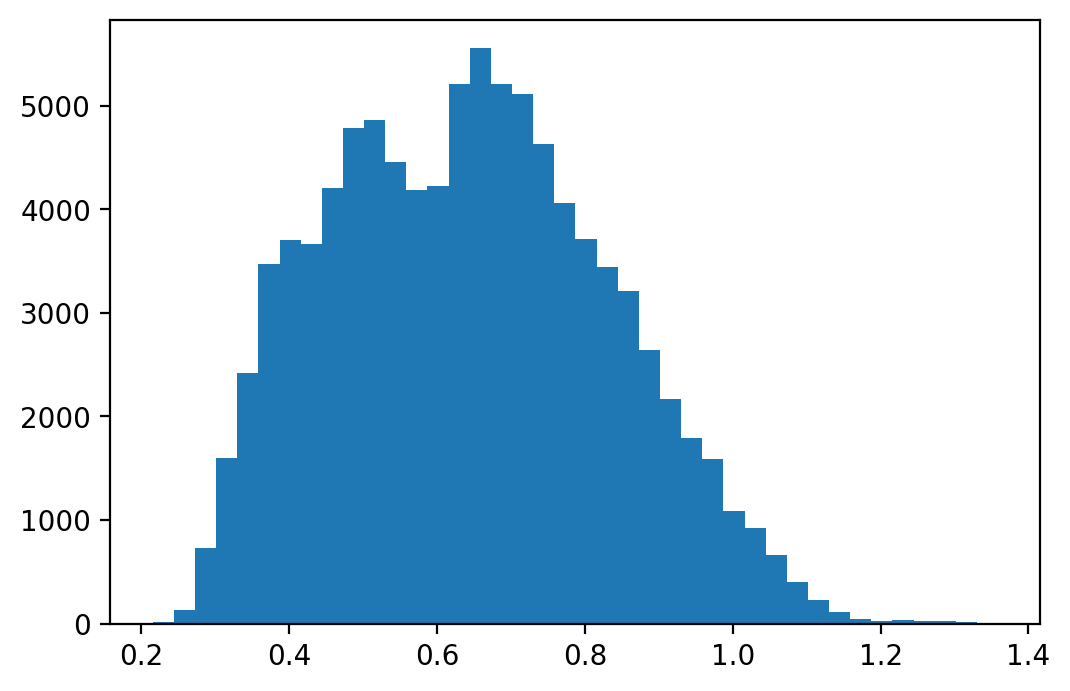

In [199]:
plt.hist(distance2,bins=40)

(array([ 198.,  850., 1580., 2313., 3031., 3701., 4076., 4474., 5546.,
        5869., 4581., 4805., 4843., 4493., 3544., 2684., 2134., 1845.,
        1631., 1548., 1545., 1605., 1652., 2033., 2139., 2286., 2339.,
        2309., 2557., 2133., 2295., 2126., 1824., 1210.,  945.,  766.,
         421.,  330.,  123.,   16.]),
 array([0.56926566, 0.6036749 , 0.6380842 , 0.6724934 , 0.7069027 ,
        0.7413119 , 0.7757212 , 0.8101304 , 0.8445397 , 0.8789489 ,
        0.9133582 , 0.94776744, 0.9821767 , 1.016586  , 1.0509952 ,
        1.0854045 , 1.1198137 , 1.154223  , 1.1886322 , 1.2230415 ,
        1.2574507 , 1.29186   , 1.3262693 , 1.3606784 , 1.3950877 ,
        1.429497  , 1.4639063 , 1.4983155 , 1.5327247 , 1.567134  ,
        1.6015433 , 1.6359525 , 1.6703618 , 1.704771  , 1.7391803 ,
        1.7735895 , 1.8079988 , 1.8424081 , 1.8768173 , 1.9112265 ,
        1.9456358 ], dtype=float32),
 <a list of 40 Patch objects>)

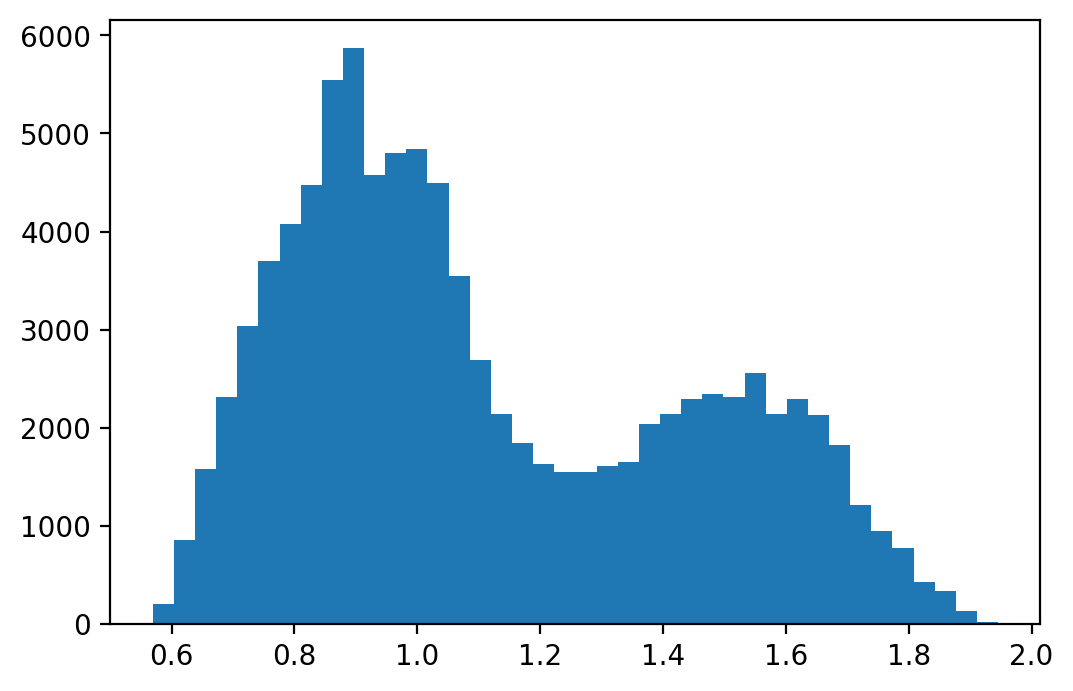

In [198]:
plt.hist(distance1,bins=40)

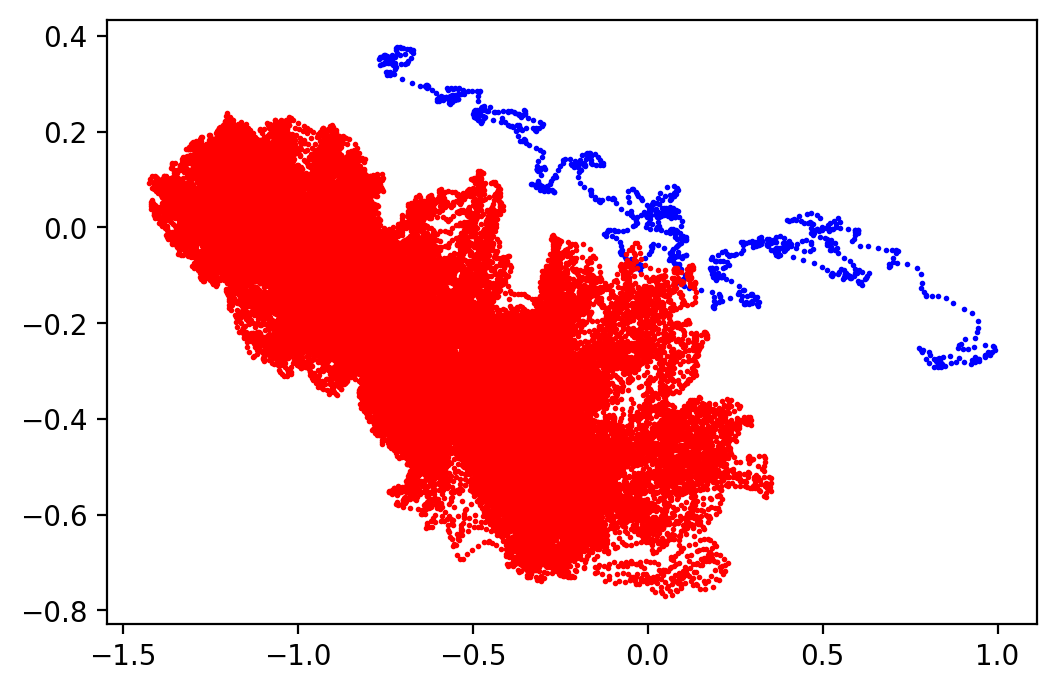

In [179]:
plt.plot(features_twin[:,0],features_twin[:,1],'bo',markersize=1)
plt.plot(features_matrix[:,0],features_matrix[:,1],'ro',markersize=1)

In [ ]:
features_matrix = features

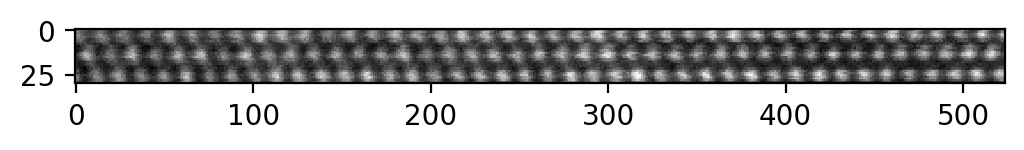

In [144]:
plt.imshow(motif_twin)

In [ ]:
descriptors_twin =  